In [3]:
# Import Necessary Libraries
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from utils.dataimporter import SoliDataImporter
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Data Loading

In [23]:
# Device type
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%load_ext autoreload
%autoreload 2

cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Data path
data_directory = "/content/drive/MyDrive/google_soli/dataset/dsp"

# Create Soli Dataloading class instance
soli_dataimporter = SoliDataImporter(data_directory)

# stacked_frames: Number of frames x 1024 x Number of channels
# labels: Number of frames
stacked_radar_data, labels = soli_dataimporter.load_deep_soli_data()

In [25]:
# Convert data into 32x32 images
stacked_images, labels = soli_dataimporter.convert_to_images(stacked_radar_data, labels)

print("Combined data shape:", stacked_images.shape)
print("Combined labels shape:", labels.shape)

Combined data shape: (169457, 32, 32, 4)
Combined labels shape: (169457,)


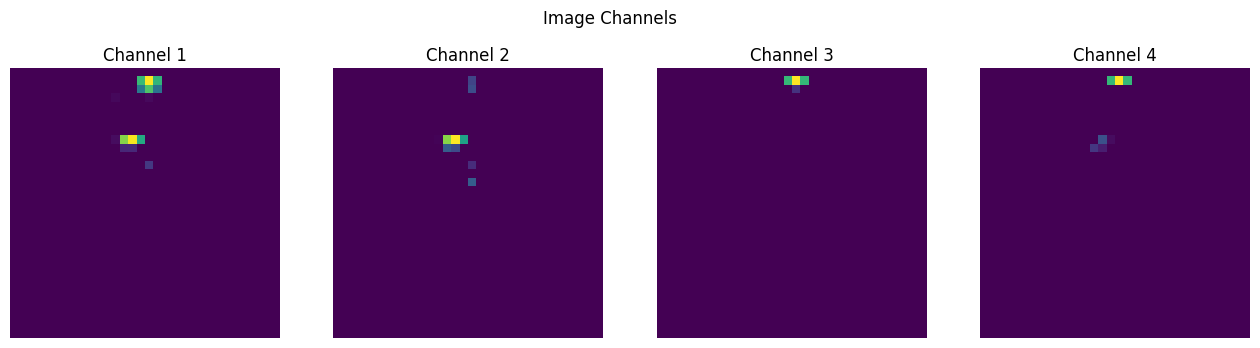

In [26]:
test_image = stacked_images[200]

# Plot each of the 4 channels separately for a test image
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for i in range(4):
    axs[i].imshow(test_image[:, :, i])
    axs[i].set_title(f'Channel {i+1}')
    axs[i].axis('off')

plt.suptitle('Image Channels')
plt.show()

In [27]:
import utils.transforms as transforms

# Computer mean and standar deviation per channel and apply normalize transform
mean, std = transforms.compute_image_mean_and_std(stacked_images)
normalize_transform = transforms.NormalizeTransform(mean, std)

compose_transform = transforms.CombineTransforms([
    normalize_transform
])

stacked_images = compose_transform(stacked_images)

In [29]:
# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(stacked_images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [30]:
# Convert numpy arrays to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Change of shape from NxHxWxC to NxCxHxW
X_train_tensor = X_train_tensor.permute(0, 3, 1, 2)
X_val_tensor = X_val_tensor.permute(0, 3, 1, 2)
X_test_tensor = X_test_tensor.permute(0, 3, 1, 2)

print(f'Train data shape: {X_train_tensor.shape}, Train labels shape: {y_train_tensor.shape}')
print(f'Val data shape: {X_val_tensor.shape}, Val labels shape: {y_val_tensor.shape}')
print(f'Test data shape: {X_test_tensor.shape}, Test labels shape: {y_test_tensor.shape}')

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Train data shape: torch.Size([118619, 4, 32, 32]), Train labels shape: torch.Size([118619])
Val data shape: torch.Size([25419, 4, 32, 32]), Val labels shape: torch.Size([25419])
Test data shape: torch.Size([25419, 4, 32, 32]), Test labels shape: torch.Size([25419])


2. Training

In [31]:
from utils.model import SoliCNNTaskA

# Create the model
num_classes = 11
model = SoliCNNTaskA(num_classes)

![Architecture](images/Architecture_A.png)

In [32]:
from utils.model_helper_functions import ModelHelper

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create a helper instance. Model helper contains functions for training and evaluating the model.
helper = ModelHelper(model, device=device)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = helper.train_model(train_loader, val_loader, num_epochs=40, learning_rate=0.00005, mult_learning_rate=0.1)

Learning rate:  5e-05
Epoch [1/40], Train Loss: 0.9954, Train Accuracy: 64.47%, Validation Loss: 0.7855, Validation Accuracy: 71.52%
Epoch [2/40], Train Loss: 0.6982, Train Accuracy: 75.02%, Validation Loss: 0.6467, Validation Accuracy: 76.59%
Epoch [3/40], Train Loss: 0.5948, Train Accuracy: 78.73%, Validation Loss: 0.5622, Validation Accuracy: 79.85%
Epoch [4/40], Train Loss: 0.5269, Train Accuracy: 81.26%, Validation Loss: 0.5077, Validation Accuracy: 82.15%
Epoch [5/40], Train Loss: 0.4744, Train Accuracy: 83.22%, Validation Loss: 0.4911, Validation Accuracy: 82.95%
Epoch [6/40], Train Loss: 0.4319, Train Accuracy: 84.80%, Validation Loss: 0.4525, Validation Accuracy: 84.06%
Epoch [7/40], Train Loss: 0.3956, Train Accuracy: 86.04%, Validation Loss: 0.4408, Validation Accuracy: 84.19%
Epoch [8/40], Train Loss: 0.3641, Train Accuracy: 87.12%, Validation Loss: 0.4074, Validation Accuracy: 85.85%
Epoch [9/40], Train Loss: 0.3378, Train Accuracy: 88.09%, Validation Loss: 0.3733, Validat

In [42]:
from torchviz import make_dot
dummy_input = torch.randn(1, 4, 32, 32).to(device)
output = model(dummy_input)
# Create the graph using make_dot
dot = make_dot(output, params=dict(model.named_parameters()))

# Save the visualization as a PNG file
dot.render('TaskA', format='png')

'TaskA.png'

In [33]:
# Save the model
torch.save(model, "/content/drive/MyDrive/google_soli/models/F_model_taskA.pth")

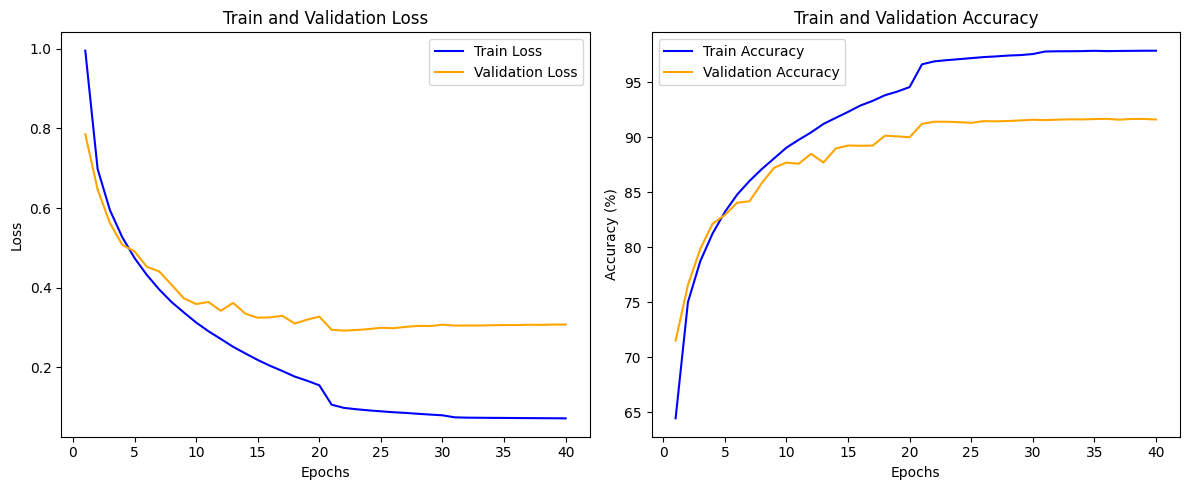

In [34]:
# Plot the accuracies and losses obtained during training
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [35]:
# Find total number and size of the parameters
total_params = 0
total_size = 0
print("Parameters per layer:")
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_params = param.numel()
        layer_size_bytes = layer_params * param.element_size()
        total_params += layer_params
        total_size += layer_size_bytes
        print(f"{name}: {layer_params} parameters, {layer_size_bytes} bytes")

print(f'Total number of parameters: {total_params}')
print(f'Total size of parameters: {total_size} bytes')
total_size_kb = total_size / (1024)
print(f'Total size of parameters: {total_size_kb:.2f} KB')


Parameters per layer:
conv1.weight: 1152 parameters, 4608 bytes
conv1.bias: 32 parameters, 128 bytes
conv2.weight: 18432 parameters, 73728 bytes
conv2.bias: 64 parameters, 256 bytes
conv3.weight: 73728 parameters, 294912 bytes
conv3.bias: 128 parameters, 512 bytes
fc1.weight: 44302336 parameters, 177209344 bytes
fc1.bias: 512 parameters, 2048 bytes
fc2.weight: 262144 parameters, 1048576 bytes
fc2.bias: 512 parameters, 2048 bytes
fc3.weight: 5632 parameters, 22528 bytes
fc3.bias: 11 parameters, 44 bytes
Total number of parameters: 44664683
Total size of parameters: 178658732 bytes
Total size of parameters: 174471.42 KB


In [36]:
print(train_losses)
print(val_losses)
print(train_accuracies)
print(val_accuracies)

[0.9953691407149777, 0.6982348705997421, 0.5948472787644428, 0.5269464551206625, 0.4744391904740376, 0.4318626463224311, 0.39564925603244966, 0.36408366471537046, 0.337837099072797, 0.3125718021687469, 0.2905651180876059, 0.2712601122908879, 0.2515636329853916, 0.23477511222534322, 0.2184557319564244, 0.2038515813383398, 0.19072507697818056, 0.17675553653127932, 0.16636086015233237, 0.15483996893299604, 0.1060646789901271, 0.09806775039400818, 0.09469826930714557, 0.0918382035450214, 0.08943752219956011, 0.08716527120681325, 0.08544300192482052, 0.08326278973988448, 0.08126238968087919, 0.07941766061738062, 0.07429484701992395, 0.07353462172960569, 0.0732487710938806, 0.0729996086666858, 0.07279626466098335, 0.0725846972670994, 0.07239180590077081, 0.07219772837524226, 0.07200401821239362, 0.07180055145846377]
[0.7855111824266565, 0.6467182543667608, 0.5622267416063345, 0.5077427548807372, 0.4910773511390266, 0.452482559536613, 0.44084794514771525, 0.40744793922083933, 0.37327189398636

3. Results

Validation Accuracy: 91.62%


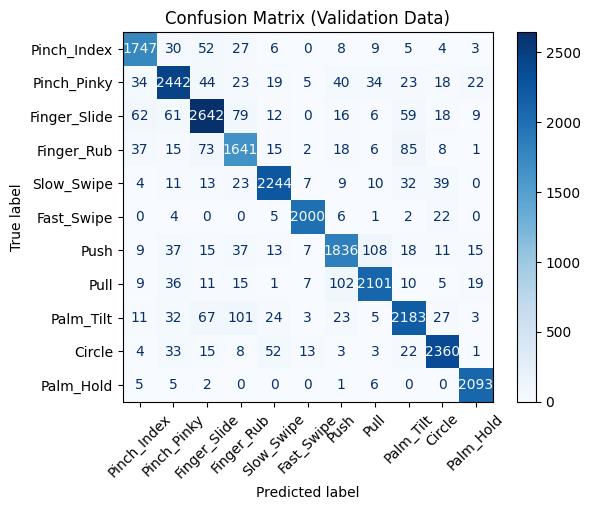

              precision    recall  f1-score   support

 Pinch_Index       0.91      0.92      0.92      1891
 Pinch_Pinky       0.90      0.90      0.90      2704
Finger_Slide       0.90      0.89      0.90      2964
  Finger_Rub       0.84      0.86      0.85      1901
  Slow_Swipe       0.94      0.94      0.94      2392
  Fast_Swipe       0.98      0.98      0.98      2040
        Push       0.89      0.87      0.88      2106
        Pull       0.92      0.91      0.91      2316
   Palm_Tilt       0.90      0.88      0.89      2479
      Circle       0.94      0.94      0.94      2514
   Palm_Hold       0.97      0.99      0.98      2112

    accuracy                           0.92     25419
   macro avg       0.92      0.92      0.92     25419
weighted avg       0.92      0.92      0.92     25419



In [37]:
# Class List
class_list = ["Pinch_Index", "Pinch_Pinky", "Finger_Slide", "Finger_Rub", "Slow_Swipe", "Fast_Swipe", "Push", "Pull", "Palm_Tilt", "Circle", "Palm_Hold"]

# Evaluate the model on validation data and get predictions
accuracy_val, loss_val, y_val_true, y_val_pred = helper.evaluate_model(model, val_loader, device)

# create confusion matrix
cm_val = confusion_matrix(y_val_true, y_val_pred)

# Print the accuracy on validation dataset
print(f'Validation Accuracy: {accuracy_val:.2f}%')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=class_list)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Validation Data)')
plt.xticks(rotation=45)
plt.show()

print(classification_report(y_val_true, y_val_pred, target_names=class_list))



Test Accuracy: 91.64%


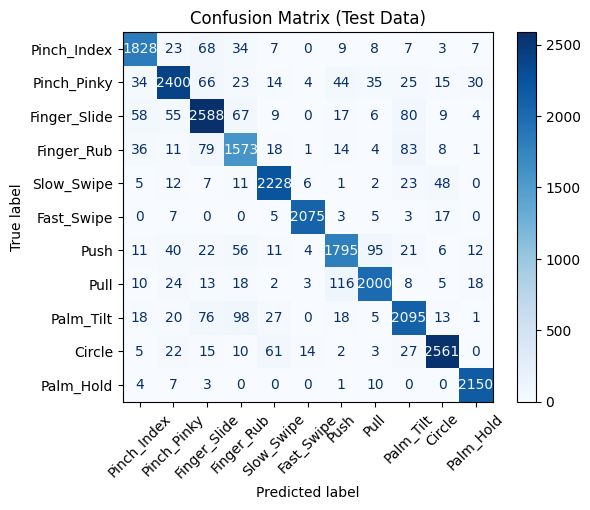

              precision    recall  f1-score   support

 Pinch_Index       0.91      0.92      0.91      1994
 Pinch_Pinky       0.92      0.89      0.90      2690
Finger_Slide       0.88      0.89      0.89      2893
  Finger_Rub       0.83      0.86      0.85      1828
  Slow_Swipe       0.94      0.95      0.94      2343
  Fast_Swipe       0.98      0.98      0.98      2115
        Push       0.89      0.87      0.88      2073
        Pull       0.92      0.90      0.91      2217
   Palm_Tilt       0.88      0.88      0.88      2371
      Circle       0.95      0.94      0.95      2720
   Palm_Hold       0.97      0.99      0.98      2175

    accuracy                           0.92     25419
   macro avg       0.92      0.92      0.92     25419
weighted avg       0.92      0.92      0.92     25419



In [38]:
# Evaluate the model on test data and get predictions
accuracy_test, loss_test, y_test_true, y_test_pred = helper.evaluate_model(model, test_loader, device)

# create confusion matrix
cm_test = confusion_matrix(y_test_true, y_test_pred)

# Print the accuracy on test dataset
print(f'Test Accuracy: {accuracy_test:.2f}%')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_list)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Data)')
plt.xticks(rotation=45)
plt.show()

print(classification_report(y_test_true, y_test_pred, target_names=class_list))